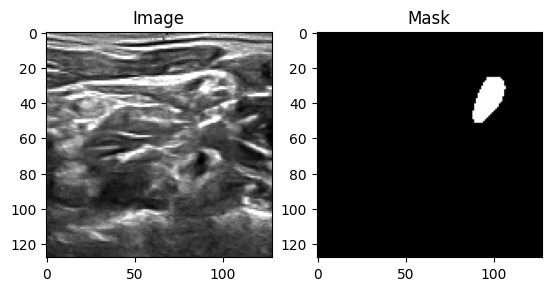

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import img_to_array, array_to_img
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Conv2D, Flatten, Dropout

# Paths for the dataset
train_path = 'C:/Users/adity/OneDrive/Desktop/ultrasound_data/train/'
test_path = 'C:/Users/adity/OneDrive/Desktop/ultrasound_data/test/'
train_masks_path = 'C:/Users/adity/OneDrive/Desktop/ultrasound_data/train/'

# Load a sample image and mask
img = image.load_img(train_path + '1_1.tif', target_size=(128, 128))
img_array = img_to_array(img)
mask = image.load_img(train_masks_path + '1_1_mask.tif', target_size=(128, 128), color_mode='grayscale')
mask_array = img_to_array(mask)

# Display image and mask
plt.subplot(1, 2, 1)
plt.imshow(img_array.astype('uint8'))
plt.title('Image')
plt.subplot(1, 2, 2)
plt.imshow(mask_array.astype('uint8'), cmap='gray')
plt.title('Mask')
plt.show()


In [2]:
# Load and preprocess the images
def preprocess_image(img):
    img = img.astype('float32') / 255.0  # Normalize the image
    return img

def load_images_from_folder(folder, size=(128, 128)):
    images = []
    for filename in os.listdir(folder):
        img = image.load_img(os.path.join(folder, filename), target_size=size)
        img = img_to_array(img)
        img = preprocess_image(img)
        images.append(img)
    return np.array(images)

# Load and preprocess data
train_images = load_images_from_folder(train_path)
train_masks = load_images_from_folder(train_masks_path)

# Check if the data is loaded correctly
print(f"Train images shape: {train_images.shape}")
print(f"Train masks shape: {train_masks.shape}")


Train images shape: (11270, 128, 128, 3)
Train masks shape: (11270, 128, 128, 3)


In [3]:
# Build Generator and Discriminator 
def build_generator():
    model = Sequential()
    model.add(Dense(256, input_dim=100))  # Latent space size
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(128 * 128 * 3, activation='tanh'))
    model.add(Reshape((128, 128, 3)))  # Output image size
    return model

def build_discriminator():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=(128, 128, 3), padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

# Compile the GAN components
def compile_gan(generator, discriminator):
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
    discriminator.trainable = False

    gan_input = Input(shape=(100,))
    generated_image = generator(gan_input)
    validity = discriminator(generated_image)

    gan = Model(gan_input, validity)
    gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

    return gan

# Create generator and discriminator
generator = build_generator()
discriminator = build_discriminator()

# Compile the GAN
gan = compile_gan(generator, discriminator)



C:\Users\adity\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\adity\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [4]:
# Train the GAN for a given epoch range
def train_gan(generator, discriminator, gan, start_epoch, end_epoch, batch_size=128, sample_interval=50):
    half_batch = batch_size // 2

    for epoch in range(start_epoch, end_epoch):
        # Train the discriminator with real images
        idx = np.random.randint(0, train_images.shape[0], half_batch)
        imgs_real = train_images[idx]
        labels_real = np.ones((half_batch, 1))  # Labels for real images
        d_loss_real = discriminator.train_on_batch(imgs_real, labels_real)

        # Train the discriminator with fake images
        noise = np.random.normal(0, 1, (half_batch, 100))  # Latent vector (random noise)
        imgs_fake = generator.predict(noise)
        labels_fake = np.zeros((half_batch, 1))  # Labels for fake images
        d_loss_fake = discriminator.train_on_batch(imgs_fake, labels_fake)

        # Total discriminator loss
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator (fool the discriminator)
        noise = np.random.normal(0, 1, (batch_size, 100))
        labels_gan = np.ones((batch_size, 1))
        g_loss = gan.train_on_batch(noise, labels_gan)

        # Print progress
        if epoch % sample_interval == 0:
            print(f'{epoch} [D loss: {d_loss[0]} | D accuracy: {100*d_loss[1]}] [G loss: {g_loss}]')
            save_generated_image(generator, epoch)

# Save generated image for evaluation
def save_generated_image(generator, epoch, path='generated_images/'):
    if not os.path.exists(path):
        os.makedirs(path)

    noise = np.random.normal(0, 1, (1, 100))
    gen_img = generator.predict(noise)
    gen_img = 0.5 * gen_img + 0.5
    img = array_to_img(gen_img[0])
    img.save(f"{path}generated_image_{epoch}.png")

# Start training in two phases
train_gan(generator, discriminator, gan, start_epoch=1, end_epoch=5001, batch_size=64, sample_interval=1000)


C:\Users\adity\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━

In [5]:
train_gan(generator, discriminator, gan, start_epoch=5001, end_epoch=10001, batch_size=64, sample_interval=1000)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


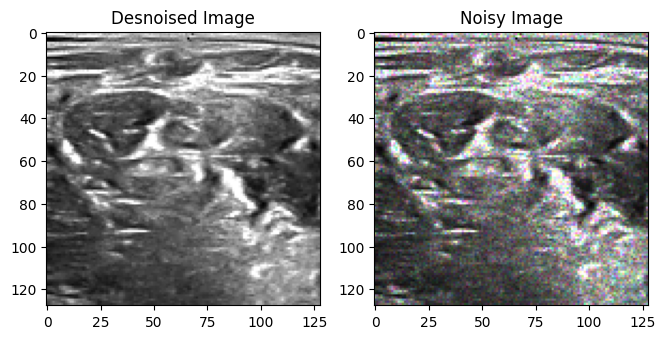

In [12]:
def add_speckle_noise(image):
    noise = np.random.randn(*image.shape)
    noisy_image = image + image * noise * 0.2 
    noisy_image = np.clip(noisy_image, 0., 1.)
    return noisy_image


def generate_denoised_output(generator, real_image):
    
    noisy_image = add_speckle_noise(real_image)
    noise = np.random.normal(0, 1, (1, 100))
    gen_img = generator.predict(noise)
    gen_img = 0.5 * gen_img + 0.5  

    return real_image, noisy_image, gen_img[0]


def show_denoising_results(generator, image_index=0):
    real_image = train_images[image_index]  
    original, noisy, denoised = generate_denoised_output(generator, real_image)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(original)
    plt.title("Original Image")

    plt.subplot(1, 3, 2)
    plt.imshow(noisy)
    plt.title("Noisy Image")

    plt.subplot(1, 3, 1)
    plt.imshow(original)
    plt.title("Desnoised Image")

    plt.show()

show_denoising_results(generator, image_index=0)


In [13]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

def calculate_psnr_ssim(original, compared):
  
    original = np.clip(original, 0, 1)
    compared = np.clip(compared, 0, 1)

    # If the image is color, compute SSIM per channel and take the mean
    if original.shape[-1] == 3:
        ssim = np.mean([
            structural_similarity(original[..., i], compared[..., i], data_range=1.0)
            for i in range(3)
        ])
    else:
        ssim = structural_similarity(original, compared, data_range=1.0)

    psnr = peak_signal_noise_ratio(original, compared, data_range=1.0)

    return psnr, ssim


In [14]:
original = train_images[0]
noisy = add_speckle_noise(original)

psnr_val, ssim_val = calculate_psnr_ssim(original, noisy)
print(f"PSNR: {psnr_val:.2f} dB, SSIM: {ssim_val:.4f}")


PSNR: 20.62 dB, SSIM: 0.7607
